In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
from numpy import expand_dims
from scipy.integrate import odeint,quad,dblquad,simps,quad_vec,nquad
import random

In [3]:
import tensorflow as tf

import keras
from keras import backend as K
from keras import datasets, layers, models
from keras.layers import Reshape, Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, BatchNormalization, SeparableConv2D, UpSampling2D, Conv2DTranspose
from keras.models import Sequential, save_model, load_model
from keras.utils import Sequence

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from matplotlib import pyplot
import pandas as pd
from glob import glob 
import csv

from sklearn.model_selection import train_test_split
from skimage.io import imread

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

import pylab as py
import threading
import scipy

from PIL import Image
import PIL
from PIL import ImageOps

from scipy import constants
from scipy import interpolate
from scipy import signal
from scipy import ndimage
from scipy.linalg import block_diag
import sympy

from matplotlib.image import imread
import skimage
from skimage.transform import rotate
from skimage.io import imshow, show, imsave
from skimage import img_as_ubyte


Using TensorFlow backend.


In [4]:
### Read the Input dataset -> Fourier Data which should look like reconstructed afterwards ###
input_df = pd.read_csv('data_cnn/labels.csv', index_col=0)
input_df['id'] = input_df.index.map(lambda id: id)
input_df['amplitude'] = input_df.index.map(lambda id: f'data_cnn/input_aug/{id}_ampl.png')
input_df['phase'] = input_df.index.map(lambda id: f'data_cnn/input_aug/{id}_phase.png')


In [5]:
# Read the Dataset we created ####
# #### this is the target dataset ->  Roconstrucet Data
target_df = pd.read_csv('data_cnn/labels.csv', index_col=0)
target_df['id'] = target_df.index.map(lambda id: id)
target_df['amplitude'] = target_df.index.map(lambda id: f'data_cnn/target_aug/{id}_ampl.png')
target_df['phase'] = target_df.index.map(lambda id: f'data_cnn/target_aug/{id}_phase.png')

# (imread(target_df.amplitude.values[0]))

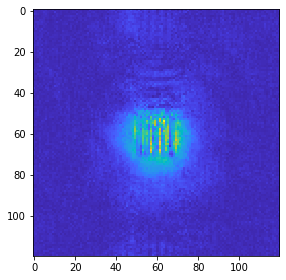

In [6]:
## path of our images (amplitude, phase)
input_path_amp = input_df.amplitude.values #input_data
input_path_ph = input_df.phase.values #input_data
target_path_amp = target_df.amplitude.values #target data
target_path_ph = target_df.phase.values #target data

##  parameters for our data ###
img_size =(120,120)
img_rows= 120
img_cols = 120
num_classes = 3
batch_size = 32
in_channels = 3 # rgb files
in_gray = 1

imshow(imread(input_path_amp[0]))

In [7]:
def read_data(file_paths, img_rows, img_cols,  channels):
    """
      Reads the fourier files from data_cnn 
        @params:
          file_paths - Array of file paths to read from
          img_rows - The image height.
          img_cols - The image width.
          as_grey - Read the image as Greyscale or RGB.
          channels - Number of channels.
        @returns:
          The created and compiled model (Model)        
    """
    images = []
  
    for file_path in file_paths:
        images.append(imread(file_path))
    
    images = np.asarray(images, dtype=np.float32)
    
    # normalize
#     images = images / 255.0 #np.max(images)

  
  # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images

In [8]:
## read the images from CSV File ####

train_input_ampli=read_data(input_df.amplitude.values, img_rows, img_cols, in_channels)
train_input_phase = read_data(input_df.phase.values, img_rows, img_cols, in_channels)

train_target_ampli=read_data(target_df.amplitude.values, img_rows, img_cols, in_channels)
train_target_phase = read_data(target_df.phase.values, img_rows, img_cols, in_channels)




# # labels - convert class vectors to binary class matrices One Hot Encoding
labels_input = input_df.appliance.values
# labels_input = keras.utils.to_categorical(labels_input, num_classes)

# # labels - convert class vectors to binary class matrices One Hot Encoding
labels_target = target_df.appliance.values
# labels_target = keras.utils.to_categorical(labels_target, num_classes)

# #  target amplitude - convert class vectors to binary class matrices One Hot Encoding
# train_target_ampli = keras.utils.to_categorical(train_target_ampli, num_classes)

# #  target phase - convert class vectors to binary class matrices One Hot Encoding
# train_target_phase = keras.utils.to_categorical(train_target_phase, num_classes)


# train_target_ampli=tf.one_hot(train_target_ampli, num_classes)
# train_target_phase=tf.one_hot(train_target_phase, num_classes)


In [9]:
train_input_comp = np.stack((train_input_ampli,train_input_phase), axis=4)
train_target_comp = np.stack((train_target_ampli,train_target_phase), axis=4)


In [10]:
# split the input data for vaidation_set
x_train_input, x_test_input, y_train_input, y_test_input = train_test_split(train_input_comp, labels_input, test_size=0.25, shuffle=False)

# take them apart
x_train_input_ampli = x_train_input[:,:,:,:,0]
x_test_input_ampli = x_test_input[:,:,:,:,0]

x_train_input_phase = x_train_input[:,:,:,:,1]
x_test_input_phase = x_test_input[:,:,:,:,1]

print(np.shape(x_test_input_phase))


# split the target data for vaidation_set
x_train_target, x_test_target, y_train_target, y_test_target = train_test_split(train_target_comp, labels_target, test_size=0.25, shuffle=False)

# take them apart
x_train_target_ampli = x_train_target[:,:,:,:,0]
x_test_target_ampli = x_test_target[:,:,:,:,0]

x_train_target_phase = x_train_target[:,:,:,:,1]
x_test_target_phase = x_test_target[:,:,:,:,1]


print(np.shape(labels_target))



# print(imshow(x_train_target_ampli[0]))


(12, 120, 120, 3)
(48,)


In [11]:
def unet(input_size = (120,120,3),num_classes=3):
    inputs = Input(input_size)
    conv1 = Conv2D(30, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(30, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(60, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(60, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(120, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(120, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(240, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(240, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(120, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([drop3,up5], axis = 3)
    conv5 = Conv2D(120, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(120, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(60, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(60, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(60, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(30, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(30, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(30, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    output = Conv2D(num_classes, 1, activation = 'softmax',padding='same')(conv7)
    


    return inputs, output


In [12]:
ampli_input, ampli_output = unet((120,120,3),num_classes)
phase_input, phase_output = unet((120,120,3),num_classes)

input_conc = concatenate([ampli_input, phase_input])
output_conc = concatenate([ampli_output, phase_output])

np.shape(input_conc)

# model = Model(input_conc, output_conc)

# model.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# model.summary()

TensorShape([Dimension(None), Dimension(120), Dimension(120), Dimension(6)])

In [13]:
model = Model(ampli_input, ampli_output)

model.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 120, 30) 840         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 120, 120, 30) 8130        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 60, 60, 30)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
# # Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(x=[x_train_input_ampli, x_train_input_phase], 
          y=[x_train_target_ampli, x_train_target_phase], 
          epochs=epochs, 
          validation_data=([x_test_input_ampli,x_test_input_phase], [x_test_target_ampli, x_test_target_phase]))

In [14]:
# Train the model, doing validation at the end of each epoch.
epochs = 100
model.fit(x=x_train_input_ampli,
          y=x_train_target_ampli, 
          epochs=epochs, 
          validation_data=(x_test_input_ampli, x_test_target_ampli))

Train on 36 samples, validate on 12 samples
Epoch 1/100
36/36 [==============================] - 39s 1s/step - loss: 1.8430 - categorical_accuracy: 0.0572 - val_loss: 1.8133 - val_categorical_accuracy: 0.7728
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 1.8161 - categorical_accuracy: 0.7667 - val_loss: 1.8124 - val_categorical_accuracy: 0.7846
Epoch 3/100
36/36 [==============================] - 39s 1s/step - loss: 1.8152 - categorical_accuracy: 0.7697 - val_loss: 1.8114 - val_categorical_accuracy: 0.7852
Epoch 4/100
36/36 [==============================] - 39s 1s/step - loss: 1.8143 - categorical_accuracy: 0.7701 - val_loss: 1.8102 - val_categorical_accuracy: 0.7858
Epoch 5/100
36/36 [==============================] - 39s 1s/step - loss: 1.8132 - categorical_accuracy: 0.7741 - val_loss: 1.8091 - val_categorical_accuracy: 0.7912
Epoch 6/100
36/36 [==============================] - 38s 1s/step - loss: 1.8120 - categorical_accuracy: 0.7793 - val_loss: 1.8080 -

36/36 [==============================] - 37s 1s/step - loss: 1.7456 - categorical_accuracy: 0.1793 - val_loss: 1.7373 - val_categorical_accuracy: 0.1714
Epoch 51/100
36/36 [==============================] - 37s 1s/step - loss: 1.7445 - categorical_accuracy: 0.1793 - val_loss: 1.7359 - val_categorical_accuracy: 0.1701
Epoch 52/100
36/36 [==============================] - 37s 1s/step - loss: 1.7433 - categorical_accuracy: 0.1789 - val_loss: 1.7346 - val_categorical_accuracy: 0.1699
Epoch 53/100
36/36 [==============================] - 37s 1s/step - loss: 1.7423 - categorical_accuracy: 0.1788 - val_loss: 1.7336 - val_categorical_accuracy: 0.1713
Epoch 54/100
36/36 [==============================] - 37s 1s/step - loss: 1.7411 - categorical_accuracy: 0.1794 - val_loss: 1.7322 - val_categorical_accuracy: 0.1715
Epoch 55/100
36/36 [==============================] - 38s 1s/step - loss: 1.7400 - categorical_accuracy: 0.1794 - val_loss: 1.7310 - val_categorical_accuracy: 0.1716
Epoch 56/100
36/3

36/36 [==============================] - 37s 1s/step - loss: 1.6994 - categorical_accuracy: 0.4211 - val_loss: 1.6879 - val_categorical_accuracy: 0.6538
Epoch 100/100
36/36 [==============================] - 37s 1s/step - loss: 1.6988 - categorical_accuracy: 0.5845 - val_loss: 1.6859 - val_categorical_accuracy: 0.5573


In [15]:
val_preds = model.predict(x_test_input_ampli)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
#     img = keras.preprocessing.image.array_to_img(mask)
    display(mask)
    
# i=2

# plt.figure()
# display(imshow(x_test_input_ampli[i]*255))

# plt.figure()
# display(imshow(x_test_target_ampli[i]*255))

# plt.figure()
# display((display_mask(i)))



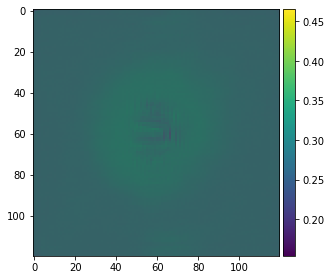

In [28]:
imshow(val_preds[10])

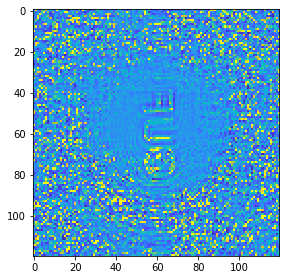

In [29]:
imshow(x_test_target_ampli[10])

In [ ]:
im2 = np.argmax(val_preds[1], axis=-1)

imshow(im2*255)

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [60, 120]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 3, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [120, 60, 30]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
#     x_outputs = Reshape((120,120))(outputs)
    print(np.shape(outputs))
    print(np.shape(inputs))

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()